### Benchmark: enum_to_string

In [1]:
!pyperf system tune

Tune the system configuration to run benchmarks

System state

CPU: use 16 logical CPUs: 0-15
Perf event: Maximum sample rate: 1 per second
ASLR: Full randomization
Linux scheduler: No CPU is isolated
CPU Frequency: 0-11=min=max=2300 MHz; 12-15=min=max=1700 MHz
CPU scaling governor (intel_pstate): performance
Turbo Boost (intel_pstate): Turbo Boost disabled
IRQ affinity: irqbalance service: inactive
IRQ affinity: Default IRQ affinity: CPU 0-15
Power supply: the power cable is plugged

Advices

Linux scheduler: Use isolcpus=<cpu list> kernel parameter to isolate CPUs
Linux scheduler: Use rcu_nocbs=<cpu list> kernel parameter (with isolcpus) to not schedule RCU on isolated CPUs

Errors

CPU Frequency: Unable to write scaling_max_freq of CPU 0: [Errno 13] Permission denied: '/sys/devices/system/cpu/cpu0/cpufreq/scaling_min_freq'
IRQ affinity: Failed to write '0000ffff' into /proc/irq/166/smp_affinity: [Errno 13] Permission denied: '/proc/irq/166/smp_affinity'
ERROR: At least one operation

In [2]:
!lstopo-no-graphics --no-io --no-legend --of txt
!cat /proc/cpuinfo | grep -m 1 -A 26 '^processor'
!getconf -a | grep CACHE

┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Machine (62GB total)                                                                                                                                                         │
│                                                                                                                                                                              │
│ ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐ │
│ │ Package L#0                                                                                                                                                              │ │
│ │                                                                                                                

In [134]:
import os
import numpy as np

TMP='/dev/shm'
CXXFLAGS='-std=c++20 -DNDEBUG -Ofast -static -march=native'
LDDFLAGS=''

def build(name, compiler, targets, size, max_len, probability, seed):
    !rm -f {' '.join([f"{TMP}/{target}" for target in targets])}
    CMD=f"CXX={compiler} \
          CXXFLAGS=\"{CXXFLAGS}\" \
          LDDFLAGS=\"{LDDFLAGS}\" \
          SIZE={size} \
          PROBABILITY={probability} \
          SEED={seed} \
          TMP={TMP} \
          BENCHMARK={name} \
          make -j -s {' '.join(targets)}"
    !{CMD}
    assert _exit_code == 0
    
def timeit(target, cpu = 1, runs = 3):
    times = []
    checksums = []
    for _ in range(runs):
        result = !taskset -c {cpu} {TMP}/{target}
        tokens = result[0].split(':')
        times.append(float(tokens[1]))
        checksums.append(int(tokens[0]))
    print('.', end='')
    return times, checksums

In [144]:
import joblib, random, string
import matplotlib.pyplot as plt
from collections import defaultdict

gperf="""
struct data {
  const char* key;
  int value;
};
%compare-strncmp
%language=C++
%enum
%includes
%readonly-tables
%global-table
%struct-type
%define slot-name key
%define lookup-function-name find
%%
"""

def generate(size, length):
    result = []
    for i in range(size):
        while True:
          new = ''.join(random.choices(string.ascii_letters + string.digits, k=random.randint(1, length)))
          if new not in result:
            result.append(new)
            break
    return result

def save(filename, size, length):
  data = generate(size, length)

  with open(filename + ".ipp", 'w') as file:
    for index, name in enumerate(data):
        file.write(f"std::pair{{\"{name}\"sv, {index}}},\n")

  with open(filename + ".gperf", 'w') as file:
    file.write(gperf)
    for index, name in enumerate(data):
        file.write(f"\"{name}\", {index}\n")

def benchmark(name, compilers, targets, sizes, combinations):
    for combination in combinations:
        _, ax = plt.subplots(1, 2, figsize=(22, 7))
        hashed_checksums = defaultdict(list)
        y_min, y_max = 0, 0

        for i, compiler in enumerate(compilers):
            results = defaultdict(list)

            for target in targets:
                for size in sizes:
                    save(f"{TMP}/data", size, combination['max_len'])
                    build(name, compiler, targets, size, **combination)
                    times, checksums = timeit(target)
                    results[target].append(np.median(times))
                    assert len(checksums) > 0 and all(checksum == checksums[0] for checksum in checksums), f"{compiler}, {target}, {size}, {combination}, {checksums}"
                    hash = joblib.hash([size, combination])
                    hashed_checksums[hash].append(checksums[0])
                    assert all(checksum == hashed_checksums[hash][0] for checksum in hashed_checksums[hash]), f"{compiler}, {target}, {size}, {combination}, {hashed_checksums[hash]}"

            for target, results in results.items():
                ax[i].plot(sizes, results, marker='o', markersize=3, label=target)
                y_min = min(y_min, min(results))
                y_max = max(y_max, max(results))

            ax[i].set_title(f"[{name}]\ncompiler: {compiler}, cxxflags: {CXXFLAGS}" + " \n" + f"{', '.join([f'{name}:{value}' for name, value in combination.items()])}", fontsize=9)
            ax[i].grid(True)
            for spine in ax[i].spines.values():
                spine.set_visible(False)
            ax[i].set_xlabel('size')
            ax[i].set_ylabel('time [s]')
            ax[i].ticklabel_format(style='plain', axis='both')
            ax[i].legend(loc='upper left')

        ax[1].yaxis.tick_right()
        for i in range(len(compilers)):
            ax[i].set_ylim(y_min, y_max * 1.1)
        
        plt.tight_layout()
        plt.show()

....................................................................................................................................

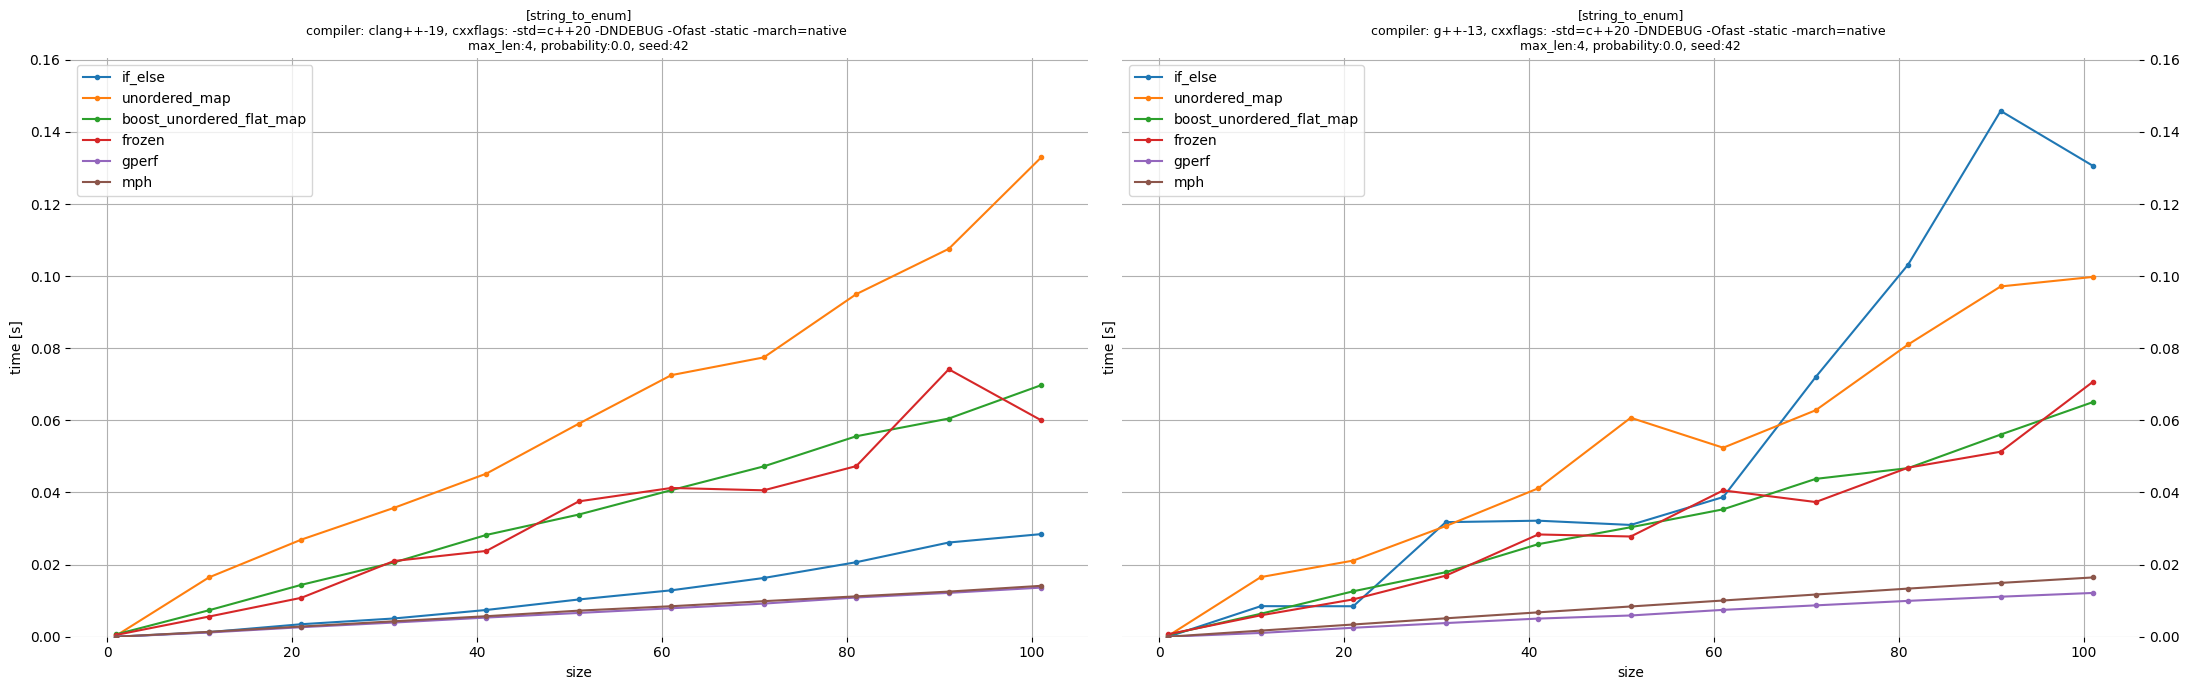

....................................................................................................................................

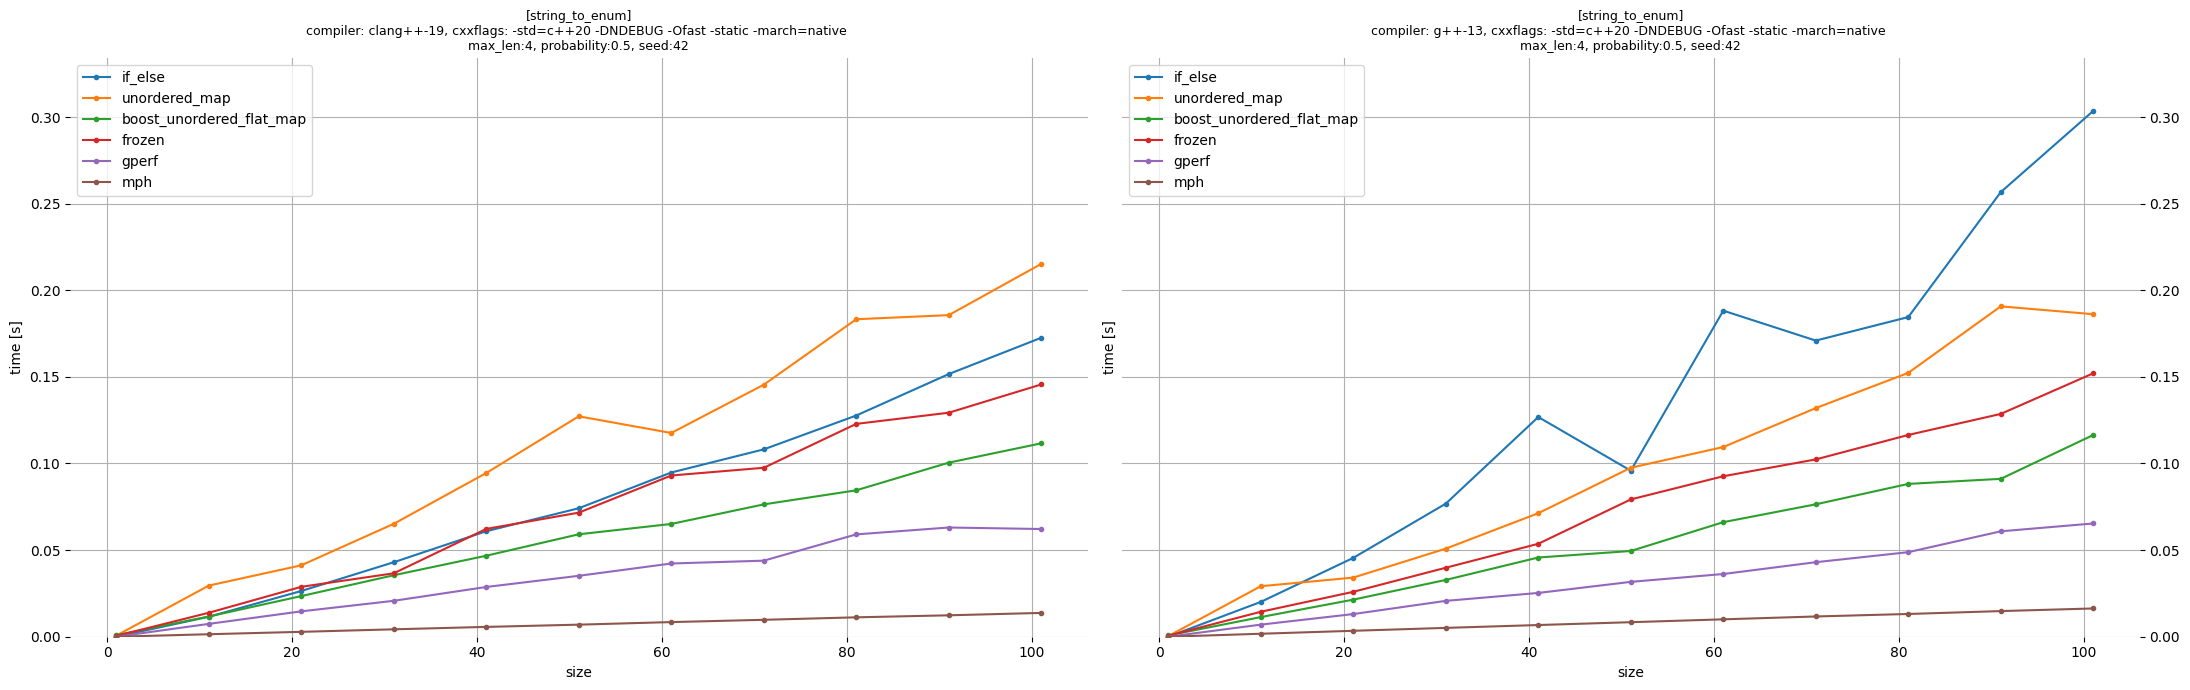

....................................................................................................................................

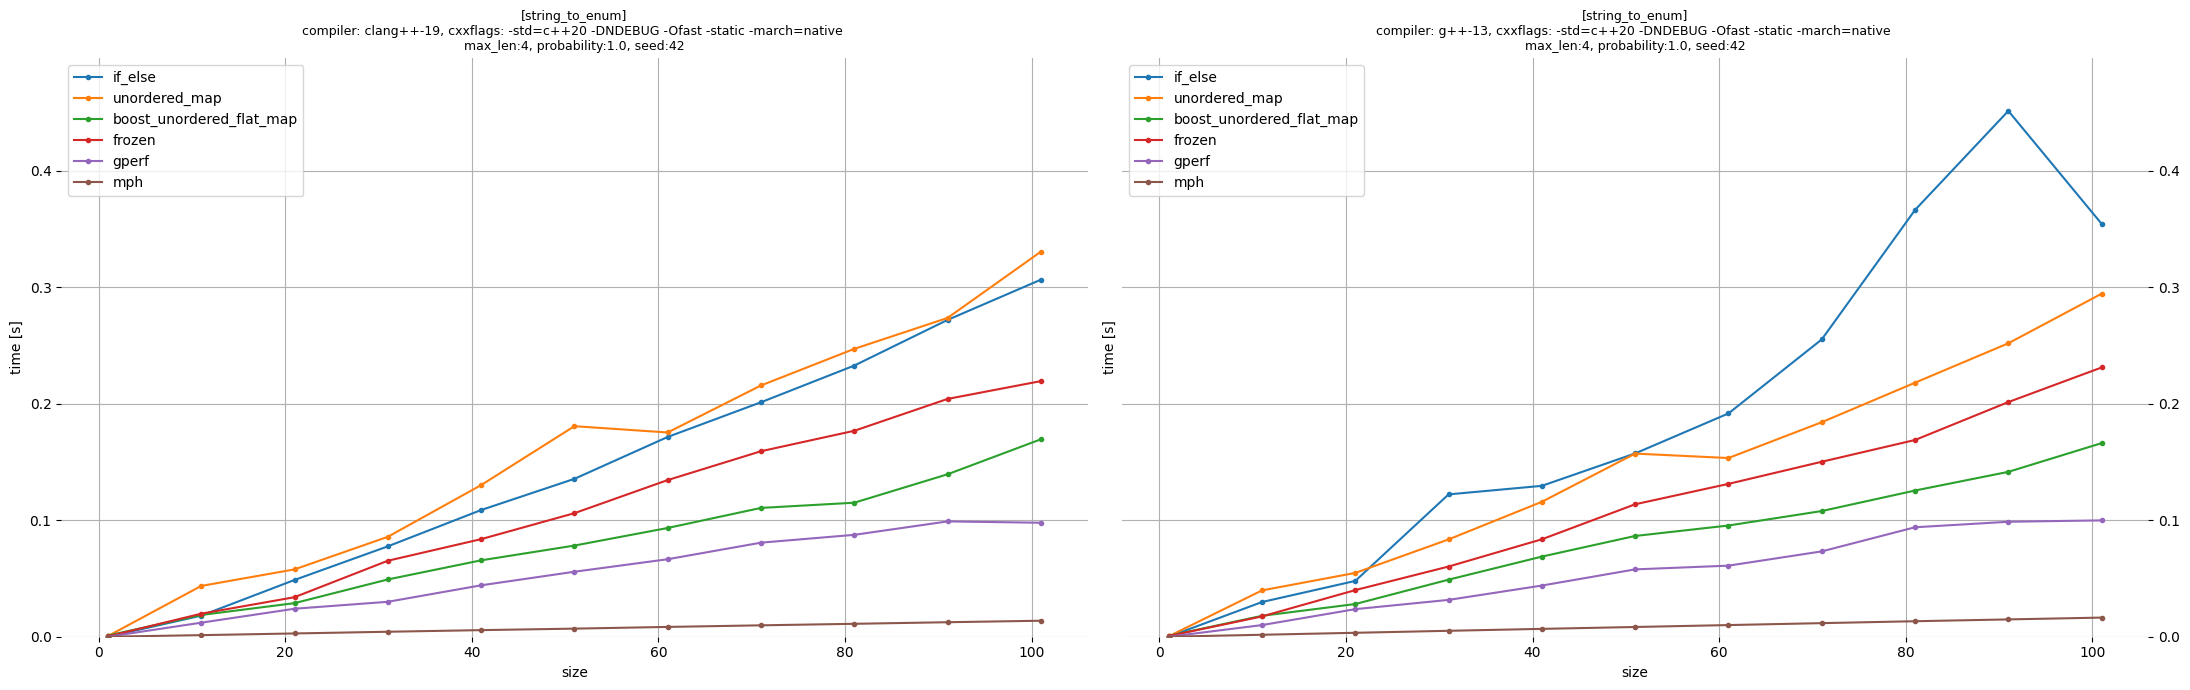

....................................................................................................................................

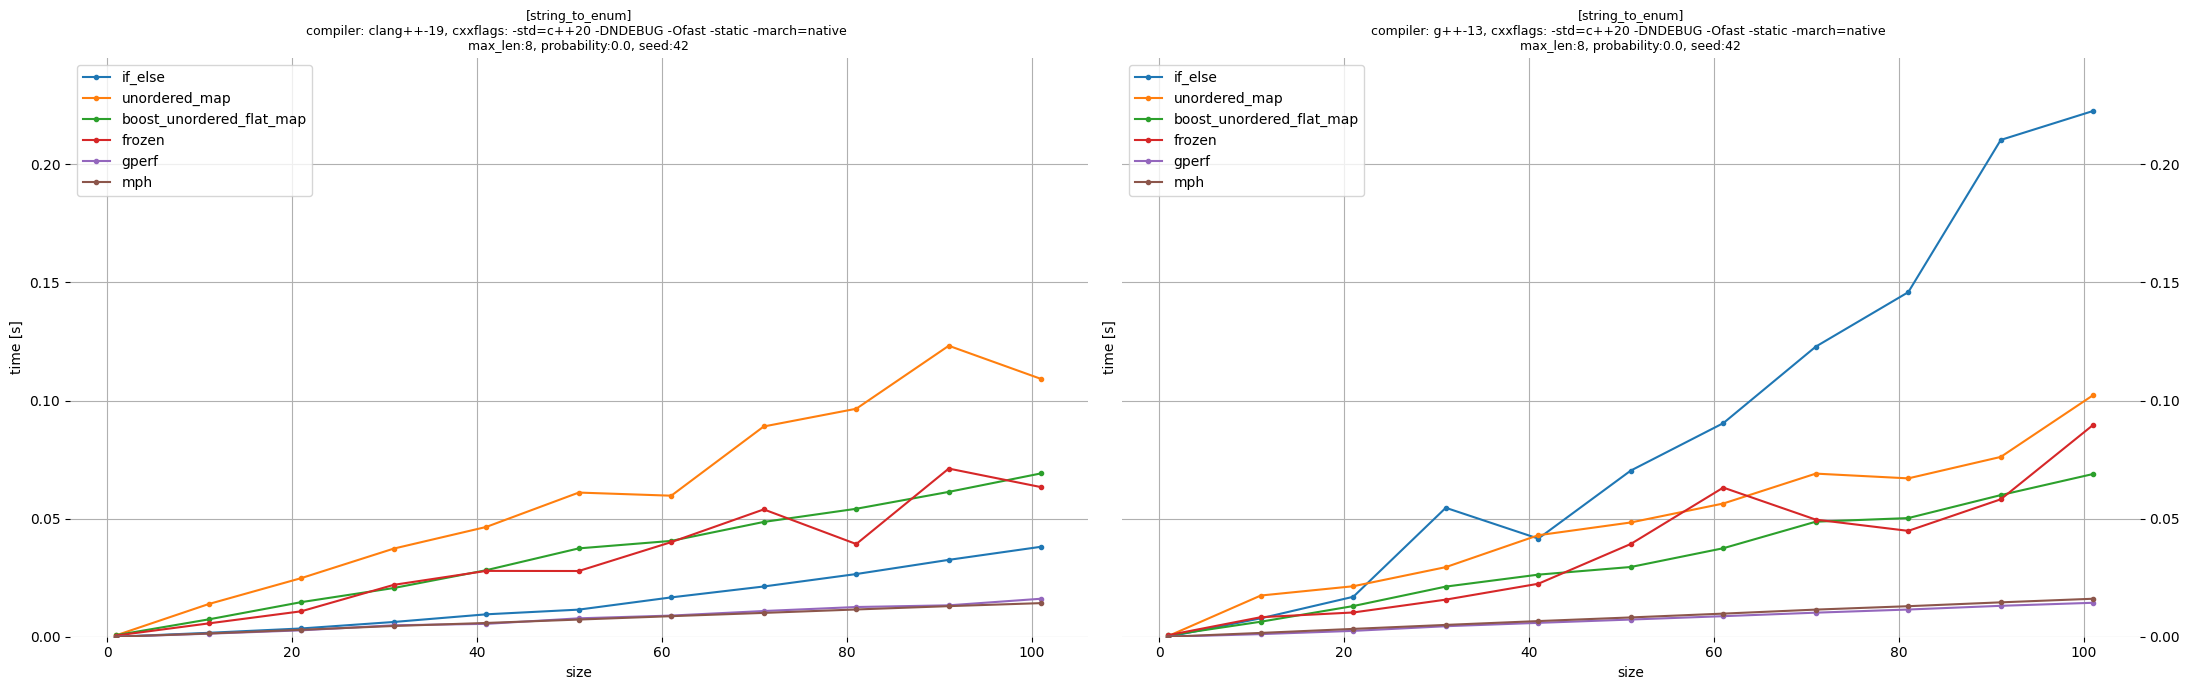

....................................................................................................................................

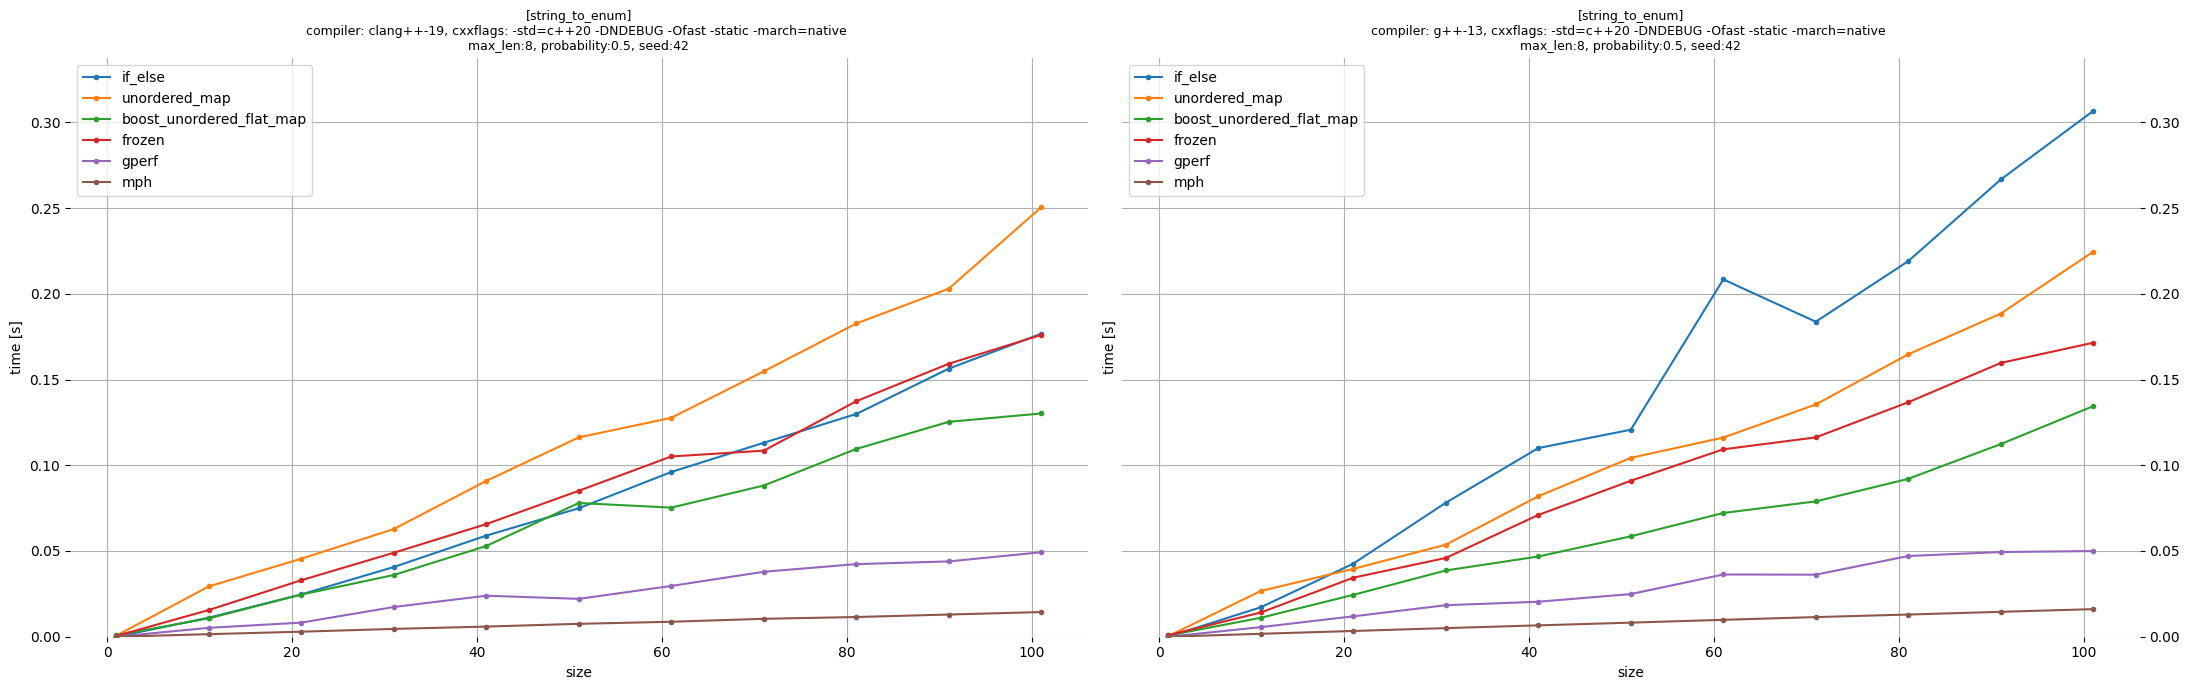

....................................................................................................................................

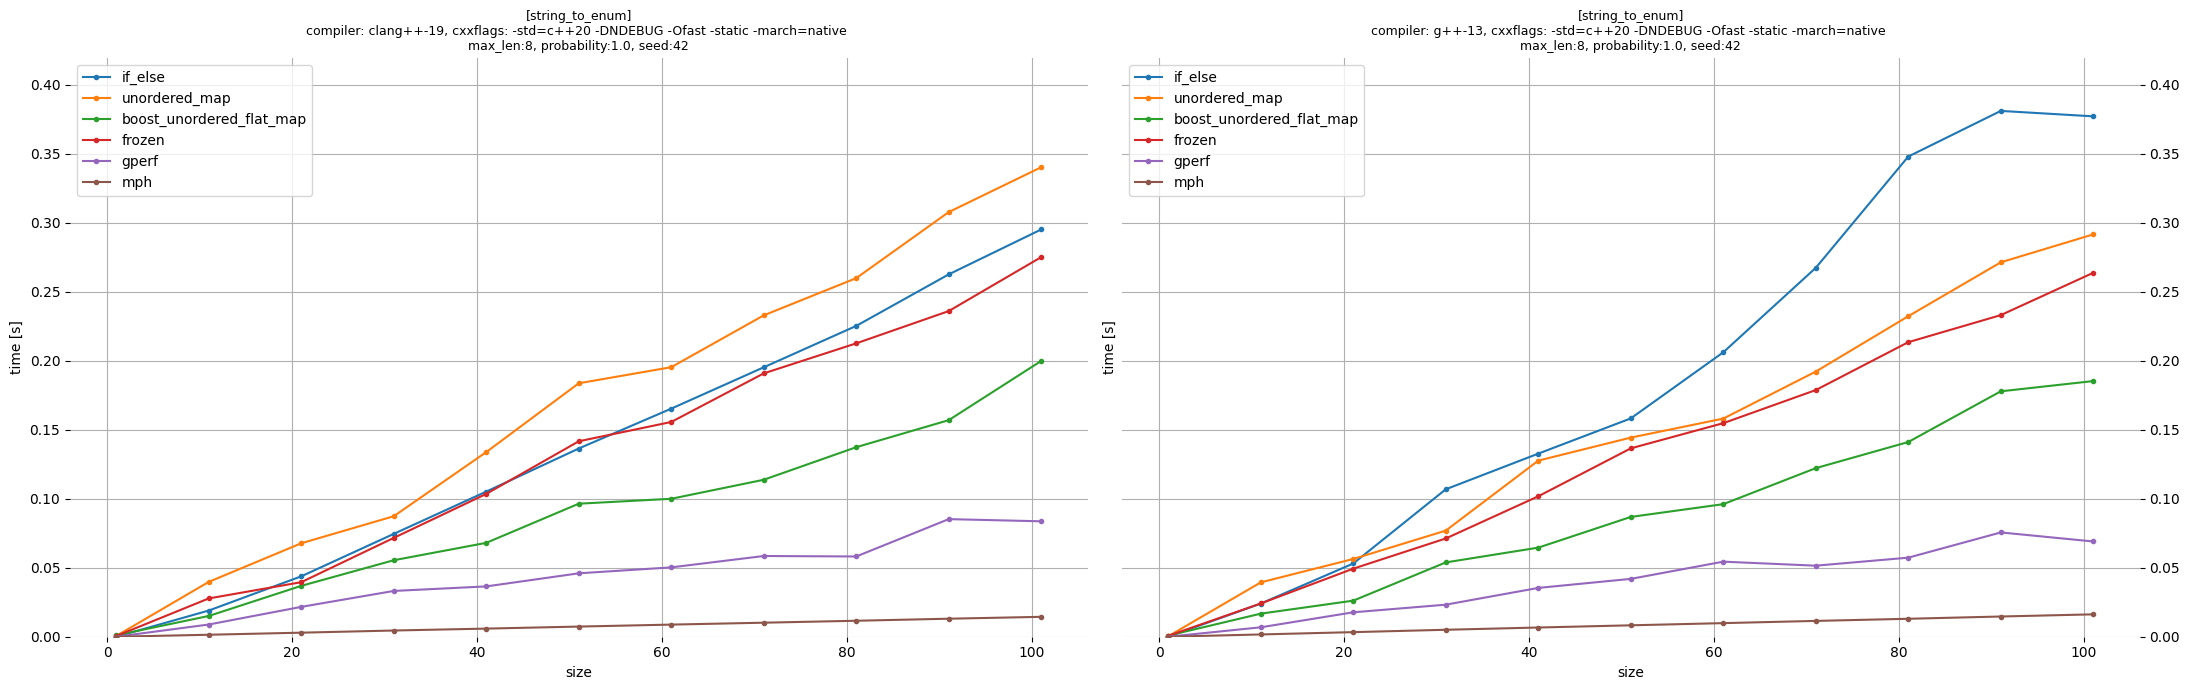

....................................................................................................................................

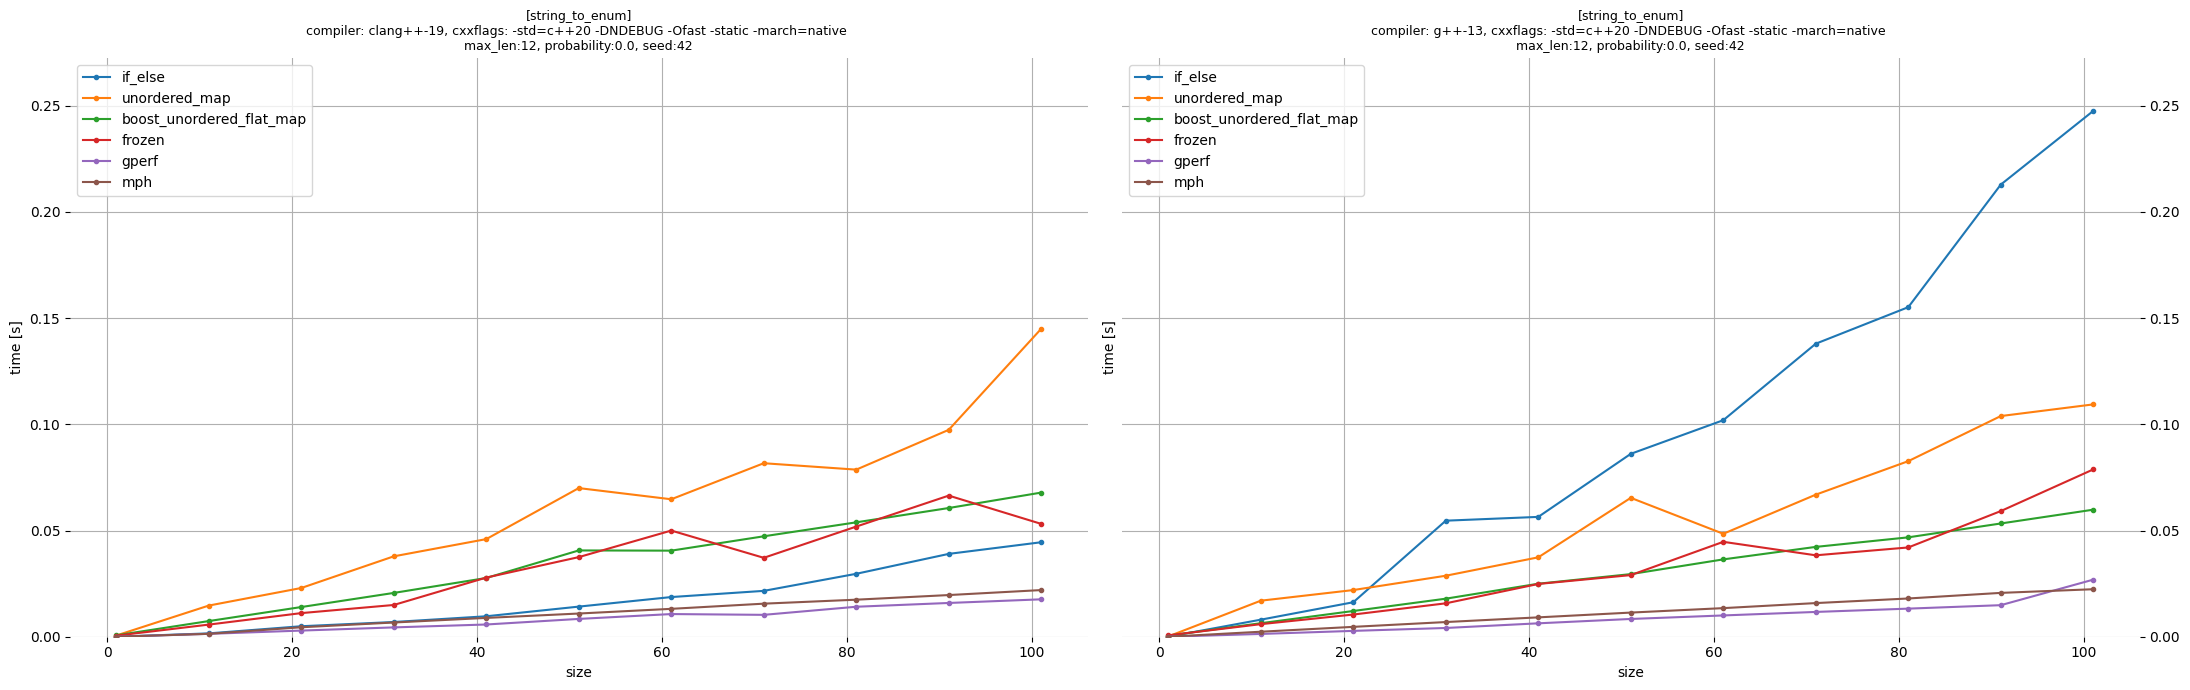

....................................................................................................................................

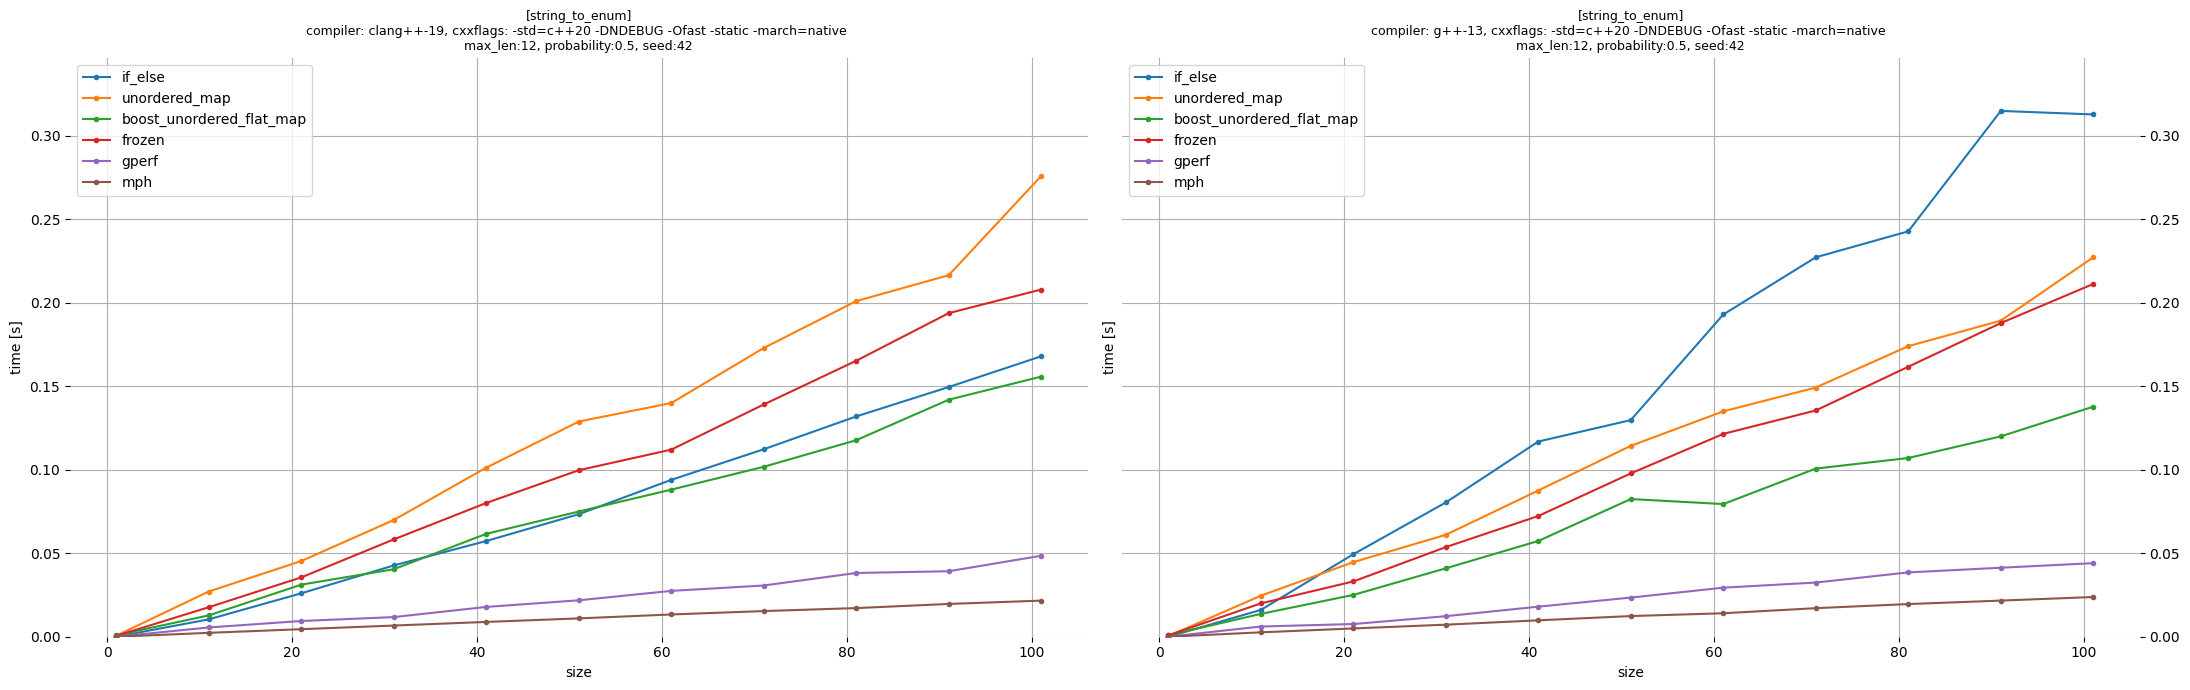

....................................................................................................................................

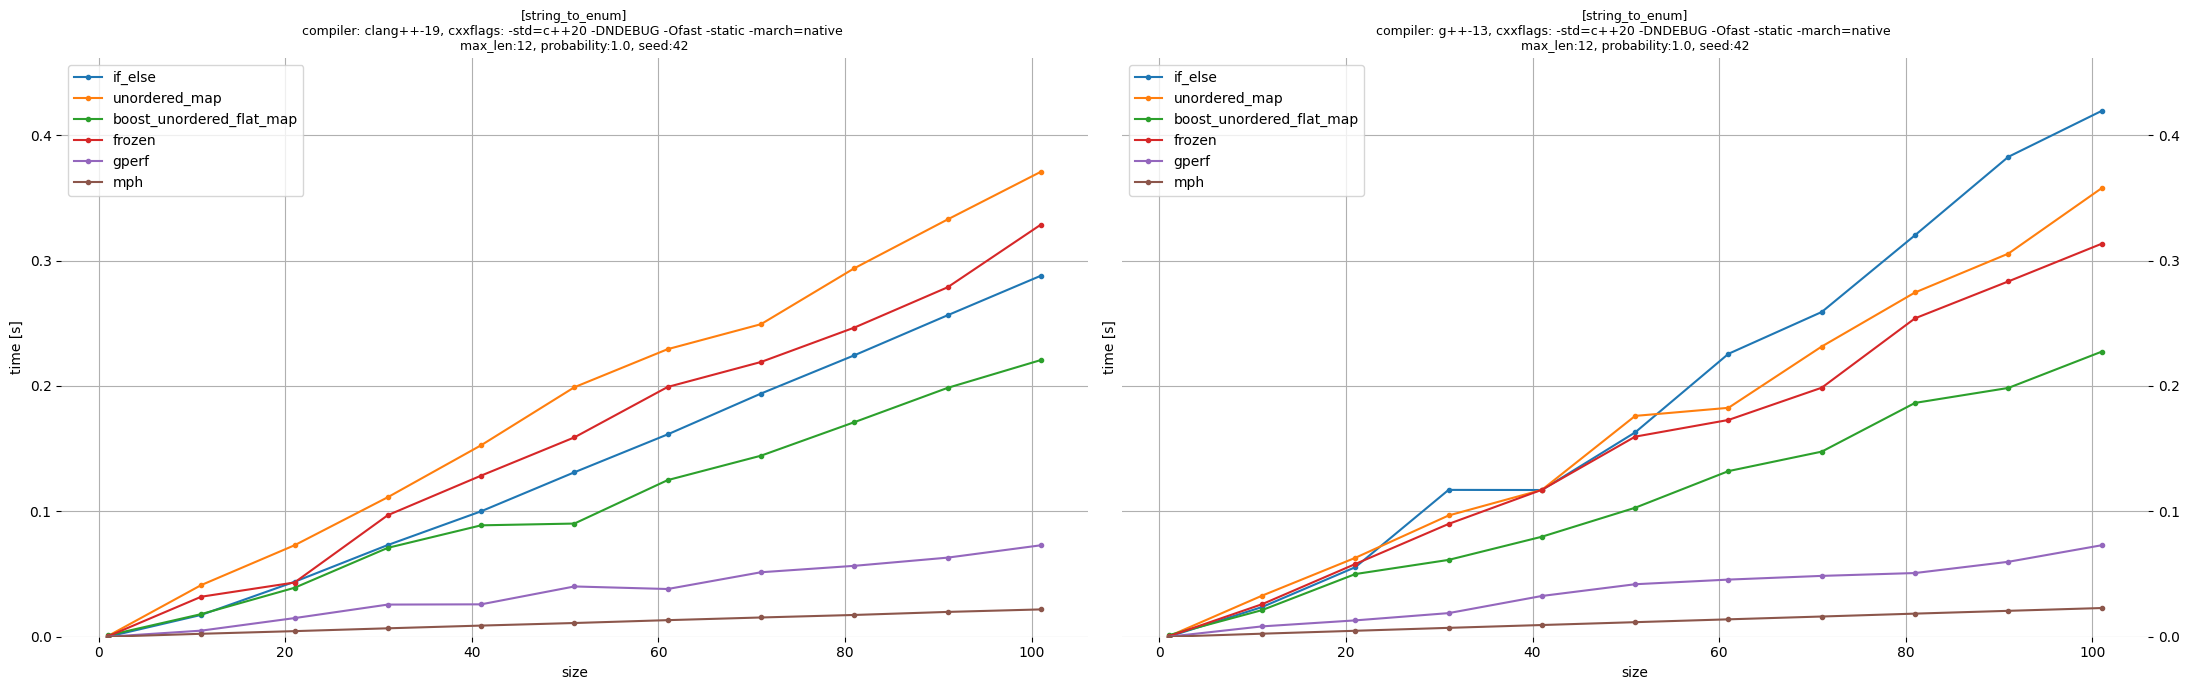

In [145]:
seed = 42

benchmark('string_to_enum', ['clang++-19', 'g++-13'],  ['if_else', 'unordered_map', 'boost_unordered_flat_map', 'frozen', 'gperf', 'mph'], sizes = range(1, 110, 10), combinations = [
    {'max_len': 4, 'probability': 0.00, 'seed': seed},
    {'max_len': 4, 'probability': 0.50, 'seed': seed},
    {'max_len': 4, 'probability': 1.00, 'seed': seed},
    
    {'max_len': 8, 'probability': 0.00, 'seed': seed},
    {'max_len': 8, 'probability': 0.50, 'seed': seed},
    {'max_len': 8, 'probability': 1.00, 'seed': seed},

    {'max_len': 12, 'probability': 0.00, 'seed': seed},
    {'max_len': 12, 'probability': 0.50, 'seed': seed},
    {'max_len': 12, 'probability': 1.00, 'seed': seed},
])